# Is the SAT unfair?  Exploring and visualizing the data to find out

### Goal of this project  

We are going to explore SAT results and NYC high school data to examine if the SAT is unfair to any particular groups of students.


### Approach


### Summary of results



# Introduction to the data

The data file `"nyc_hs_data_clean.csv"`, located in the `"data/processed"` folder of this project, was produced by running the [cleaning-nyc-hs-data](https://github.com/JustinToribio/cleaning-nyc-hs-data) project, which can also be found in this GitHub repository.  We will read the csv file into a dataframe named `data` and view the first 5 rows.

There are 362 rows (1 for each school) and 79 columns in `data`, which contains NYC SAT results by school for the graduating seniors of 2012 in the first few columns.  At the time of this writing, this was the most recent SAT data available.  The remaining columns contain graduation, AP (advanced placement), class size, demographic, school survey and location data for the same school year (or as close to it as possible if the 2012 data was not available).

In [1]:
# Import pandas module and set maximum viewable columns and rows to 500.
import pandas as pd
pd.options.display.max_columns = 500  
pd.options.display.max_rows = 500

# Read csv file into a dataframe named "data" and view the first 5 rows.
data = pd.read_csv("../data/processed/nyc_hs_data_clean.csv")
data.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,Num of AP Test Takers,Num of AP Total Exams Taken,Num of AP Exams Passed,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_s_11,saf_t_11,saf_p_11,saf_tot_11,eng_s_11,eng_t_11,eng_p_11,eng_tot_11,aca_s_11,aca_t_11,aca_p_11,aca_tot_11,com_s_11,com_t_11,com_p_11,com_tot_11,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29.0,355.0,404.0,363.0,1122.0,78.0,43.0,55.1,36.0,46.2,83.7,0.0,0.0,0.0,36.0,46.2,83.7,7.0,9.0,16.3,16.0,20.5,11.0,14.1,18.096134,19.175354,13.554735,88.000000,4.000000,22.564286,18.500000,26.571429,88.6,422.0,94.0,22.3,105.0,24.9,34.0,35.0,59.0,14.0,123.0,29.1,227.0,53.8,7.0,1.7,259.0,61.4,163.0,38.6,89.0,70.0,39.0,379.000000,26.0,151.0,6.00000,6.3,7.8,6.7,6.100000,6.1,7.4,6.6,6.700000,6.5,7.6,7.0,5.600000,5.3,7.7,6.2,40.713764,-73.985260,1
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91.0,383.0,423.0,366.0,1172.0,124.0,53.0,42.7,42.0,33.9,79.2,8.0,6.5,15.1,34.0,27.4,64.2,11.0,8.9,20.8,46.0,37.1,20.0,16.1,37.000000,53.000000,21.000000,105.687500,4.750000,22.231250,18.250000,27.062500,71.8,394.0,83.0,21.1,86.0,21.8,55.0,10.0,115.0,29.2,89.0,22.6,181.0,45.9,9.0,2.3,226.0,57.4,168.0,42.6,84.0,95.0,10.0,385.000000,37.0,46.0,6.00000,6.6,7.9,6.8,6.300000,6.6,7.2,6.7,7.000000,7.3,7.3,7.2,5.700000,5.8,7.4,6.3,40.712332,-73.984797,1
2,01M450,EAST SIDE COMMUNITY SCHOOL,70.0,377.0,402.0,370.0,1149.0,90.0,70.0,77.8,67.0,74.4,95.7,0.0,0.0,0.0,67.0,74.4,95.7,3.0,3.3,4.3,15.0,16.7,5.0,5.6,12.000000,12.000000,20.562084,57.600000,2.733333,21.200000,19.400000,22.866667,71.8,598.0,30.0,5.0,158.0,26.4,91.0,19.0,58.0,9.7,143.0,23.9,331.0,55.4,62.0,10.4,327.0,54.7,271.0,45.3,0.0,98.0,28.0,422.207196,42.0,150.0,6.79888,7.3,8.7,7.9,6.832925,8.0,8.1,7.9,7.594217,8.8,8.4,8.4,6.151669,8.0,8.2,7.9,40.729783,-73.983041,1
3,01M509,MARTA VALLE HIGH SCHOOL,44.0,390.0,433.0,384.0,1207.0,84.0,47.0,56.0,40.0,47.6,85.1,17.0,20.2,36.2,23.0,27.4,48.9,7.0,8.3,14.9,25.0,29.8,5.0,6.0,14.000000,15.000000,13.779655,69.642857,3.000000,23.571429,20.000000,27.357143,80.7,367.0,41.0,11.2,95.0,25.9,28.0,36.0,34.0,9.3,116.0,31.6,209.0,56.9,6.0,1.6,170.0,46.3,197.0,53.7,90.0,100.0,21.0,306.000000,29.0,69.0,6.40000,6.4,7.7,6.9,6.400000,6.1,7.2,6.6,7.000000,6.8,7.3,7.0,5.900000,5.3,7.4,6.2,40.720569,-73.985673,1
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159.0,522.0,574.0,525.0,1621.0,46.0,46.0,100.0,46.0,100.0,100.0,31.0,67.4,67.4,15.0,32.6,32.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,306.000000,587.000000,323.000000,156.368421,6.157895,25.510526,19.473684,31.210526,23.0,1613.0,4.0,0.2,43.0,2.7,2.0,0.0,448.0,27.8,189.0,11.7,229.0,14.2,725.0,44.9,794.0,49.2,819.0,50.8,98.0,68.0,51.0,923.000000,67.0,736.0,7.30000,7.6,8.5,7.8,7.000000,5.9,7.9,6.9,7.700000,7.3,8.4,7.8,6.400000,5.6,7.9,6.7,40.718725,-73.979426,1


# The SAT may be geographically biased - mapping SAT scores  

We will begin by creating a color-mapped scatter plot of mean SAT scores, by school district, on a map of NYC.  This will give us a good visualization of any geographic patterns in SAT scores that we can explore further.  

We are plotting the data by school district because plotting each individual school will make the map too cluttered and it will not convey any useful insights.  To group the data by school district we will take the mean of the latitudes, longitudes and SAT scores of all of the schools in a district.  

First we will create a function named `create_nyc_map` that will allow us to generate the map with different color-mapped sets of data and customizations.  Then we will call on the function to create and display the map of SAT scores.

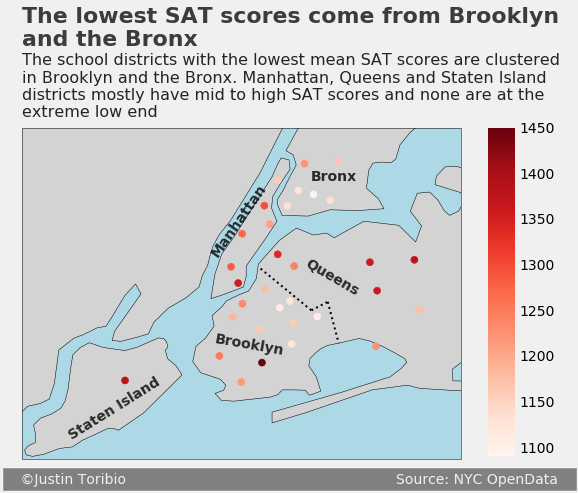

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeat


def create_nyc_map(column_name, title=None, title_y_adj=0.0,
                   subtitle=None, subtitle_y_adj=0.0, fig_size=[7,7], 
                   colorbar_ticks=None, colorbar_tick_labels=None):
    """
    Create a color-mapped plot of school districts on a map of NYC.
    
    Arguments:
    column_name -- The column name from "data" to derive the color-map
                   from.
    title -- The title of the map (default None).
    title_y_adj -- The amount of vertical adjustment to the default
                   position of the title, in units of latitude. Can be +
                   or - floats (default 0.0).
    subtitle -- The subtitle of the map (default None).
    subtitle_y_adj -- The amount of vertical adjustment to the default
                      position of the subtitle, in units of latitude. 
                      Can be + or - floats (default 0.0).
    fig_size -- [width, height] of the map plot (default [7,7]).
    colorbar_ticks -- List of quantitative tick labels for the color-bar
                      legend. If None, ticks are determined
                      automatically from the input (default None).
    colorbar_tick_labels -- List of custom tick labels (quantitative or
                            string) for the color-bar legend. The 
                            "colorbar_ticks" arg must be defined with a
                            list of quantitative values of at least the 
                            same length. I.e. for custom tick labels of 
                            ["10m", "20m", "30m"], "colorbar_ticks" must 
                            be defined with [10, 20, 30] at least. 
                            (default None).
    
    Returns:
    The figure and axes objects of the plot.
    """

    # Group the data by school district and assign the map data to
    # variables.
    districts = data.groupby("school_dist").agg(np.mean)
    districts.reset_index(inplace=True)
    longitudes = districts["lon"].tolist()
    latitudes = districts["lat"].tolist()
    state_borders = cfeat.NaturalEarthFeature(name="admin_1_states_provinces",
                                              scale="10m", category="cultural")
    signature = ("   ©Justin Toribio                               "
                 "                             Source: NYC OpenData   ")
    
    # Create the map, scatter plot of school districts and color-bar legend.
    style.use("fivethirtyeight")
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    ax.background_patch.set_facecolor("lightblue")
    ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
    ax.set_extent([-74.255735, -73.700272, 40.496044, 40.915256])
    districts_plot = ax.scatter(longitudes, latitudes, s=50, zorder=2,
                                cmap="Reds", c=districts[column_name])
    colorbar_axes = fig.add_axes([1, .15, 0.06, 0.657]) 
    colorbar = plt.colorbar(districts_plot, cax=colorbar_axes,
                            ticks=colorbar_ticks)
    if (colorbar_ticks is None) or (colorbar_tick_labels is None):
        pass
    else:
        colorbar.ax.set_yticklabels(colorbar_tick_labels)

    # Add all of the text to the map.
    ax.text(s=title, x=-74.255735, y=41.02+title_y_adj, fontsize=22,
            weight="bold", alpha=.75)
    ax.text(s=subtitle, x=-74.255735, y=40.93+subtitle_y_adj, fontsize=16,
            alpha=.85)
    ax.text(s=signature, x=-74.275, y=40.466, fontsize=14, color="#f0f0f0",
            backgroundcolor="grey")
    ax.text(s="Bronx", x=-73.89, y=40.85, color="black", alpha=.8,
            weight="bold", rotation=0)
    ax.text(s="Manhattan", x=-74.02, y=40.835, color="black", alpha=.8,
            weight="bold", rotation=55) # x=-74.013, y=40.85
    ax.text(s="Brooklyn", x=-74.013, y=40.644, color="black", alpha=.8,
            weight="bold", rotation=-10)
    ax.text(s="Queens", x=-73.9, y=40.74, color="black", alpha=.8,
            weight="bold", rotation=-30)
    ax.text(s="Staten Island", x=-74.2, y=40.59, color="black", alpha=.8,
            weight="bold", rotation=32)

    # Draw the boundary between Brooklyn and Queens.
    ax.plot([-73.954010, -73.889662], [40.737324, 40.684499],
            color="black", linewidth=2, linestyle="dotted")
    ax.plot([-73.889662, -73.868921], [40.684499, 40.695223],
            color="black", linewidth=2, linestyle="dotted")
    ax.plot([-73.868921, -73.855090], [40.695223, 40.642811],
            color="black", linewidth=2, linestyle="dotted")
    
    return fig, ax


# Assign the title and subtitle of the map to variables.
title = ("The lowest SAT scores come from Brooklyn\n"
         "and the Bronx")
subtitle = (
    "The school districts with the lowest mean SAT scores are clustered\n"
    "in Brooklyn and the Bronx. Manhattan, Queens and Staten Island\n"
    "districts mostly have mid to high SAT scores and none are at the\n"
    "extreme low end"
)

# Create and display the map of SAT scores.
create_nyc_map("sat_score", title=title, subtitle=subtitle)
plt.show()

In the map above, each dot represents 1 of the 32 school districts across the 5 boroughs of NYC.  The color of each dot is a shade of red, which represents the mean SAT score across all of the schools in that district.  Referring to the color-bar legend to the right of the map, lighter and darker red dots represent lower and higher mean SAT scores, respectively.  

The school districts with the lowest mean SAT scores are clustered in Brooklyn and the Bronx.  With the exception of 1 district in Brooklyn, which actually has the highest mean SAT score (the darkest red dot), all of the other districts in these 2 boroughs score on the low end of the range.  They are also the only boroughs with districts that score on the extreme low end (the nearly white dots).  

The majority of districts in Manhattan, Queens and Staten Island score on the mid to high end of the range and none are at the extreme low end.  

This suggests there is potentially some geographic bias in the SAT, which could be associated with any number of factors: demographic, socio-economic, educational standards and environment etc...  We will attempt to uncover the nature of any potential bias in the rest of this project.

# Finding the nature of any bias in the SAT  

To begin finding the nature of any potential bias in the SAT, we will determine which columns in the data are most strongly correlated with SAT scores.  We will do this by viewing a horizontal bar plot of correlation coefficients between each column and the `"sat_score"` column in `data`.  

The correlation coefficient measures the strength and direction of a linear relationship between two quantitative variables.  The maximum possible value is +1, indicating a perfect positive linear relationship (as one variable increases, the other variable *increases* in linear proportion).  The minimum possible value is –1, indicating a perfect negative linear relationship (as one variable increases, the other variable *decreases* in linear proportion).  A coefficient of 0 indicates no linear relationship between the two variables.  

Correlation does not necessarily indicate *causality* (that an increase in one variable *causes* an increase or decrease in the other variable).   It is only an indication of the strength and direction of a linear relationship between two variables.

Since we only care about strong correlations, the bar plot will only show columns that have a coefficient with `"sat_score"` greater than 0.5 or less than -0.5.  We will also filter out any columns pertaining to SAT scores, since that is our target variable.

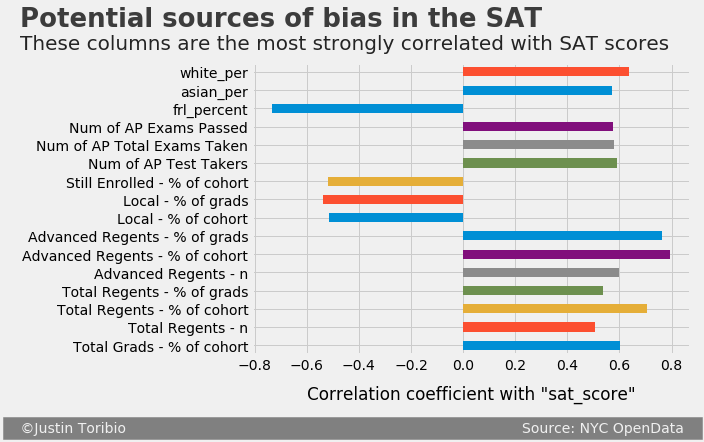

In [3]:
# Create a dataset with only columns that have a correlation coefficient 
# with "sat_score" greater than 0.5 or less than -0.5, and drop the
# SAT columns.
correlations = data.corr()["sat_score"]
filtered_correlations = correlations[abs(correlations) > 0.5]
filtered_correlations.drop(["sat_score", 
                            "SAT Writing Avg. Score",
                            "SAT Critical Reading Avg. Score",
                            "SAT Math Avg. Score"], inplace=True)

# Assign the text of the bar plot to variables.
title = "Potential sources of bias in the SAT"
subtitle = "These columns are the most strongly correlated with SAT scores"
x_axis_label = 'Correlation coefficient with "sat_score"'
signature = (
    "   ©Justin Toribio                                               "
    "                                         Source: NYC OpenData   "
)

# Create the bar plot, add the text and display the plot.
style.use("fivethirtyeight")
graph = filtered_correlations.plot.barh(figsize=[7,5])
graph.set_xlabel(x_axis_label, labelpad=13)
graph.text(s=title, x=-1.7, y=17.5, fontsize=26, weight="bold", alpha=.75)
graph.text(s=subtitle, x=-1.7, y=16.25, fontsize=20, alpha=.85)
graph.text(s=signature, x=-1.75, y=-4.75, fontsize=14, color="#f0f0f0",
           backgroundcolor="grey")
plt.show()

# Selecting the potential sources of bias to explore further

### Demographic data columns  

The first 3 column names in the bar plot above (`"white_per"` to `"frl_percent"`) all pertain to demographic data.  We will select all of these columns to explore further since each gives information on a different demographic group.  

### AP data columns  

The 4th through 6th column names in the bar plot above (`"Num of AP Exams Passed"` to `"Num of AP Test Takers"`) all pertain to AP results data.  We will select the most positively correlated column (`"Num of AP Test Takers"`) to explore further and drop the rest since they all provide related information.  

### Graduation data columns  

The last 10 column names in the list above (`"Still Enrolled - % of cohort"` to `"Total Grads - % of cohort"`) all pertain to graduation data.  We will select the most positively correlated column (`"Advanced Regents - % of cohort"`) and most negatively correlated column (`"Local - % of grads"`) to explore further and drop the rest since they all provide related information.    
 
Finally, we will view the horizontal bar plot again with only the final selected columns.

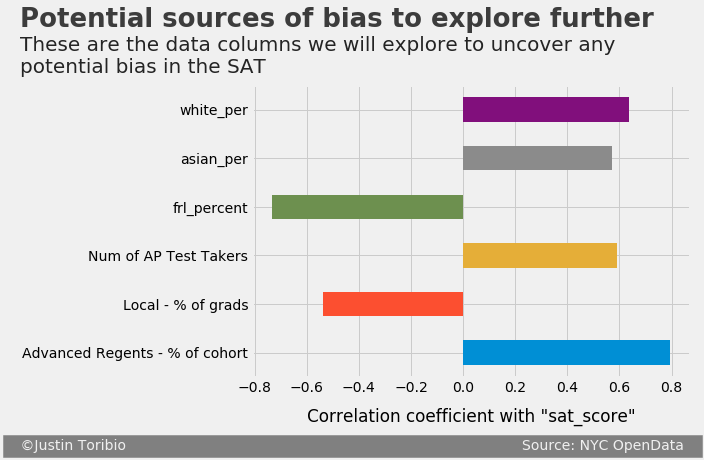

In [4]:
# Drop the columns to be removed from the dataset.
filtered_correlations.drop(["Num of AP Total Exams Taken",
                            "Num of AP Exams Passed",
                            "Total Grads - % of cohort",
                            "Total Regents - n",
                            "Total Regents - % of cohort",
                            "Total Regents - % of grads",
                            "Advanced Regents - n",
                            "Advanced Regents - % of grads",
                            "Local - % of cohort",
                            "Still Enrolled - % of cohort"], inplace=True)

# Assign the text of the bar plot to variables.
title = "Potential sources of bias to explore further"
subtitle = ("These are the data columns we will explore to uncover any\n"
            "potential bias in the SAT")
x_axis_label = 'Correlation coefficient with "sat_score"'
signature = (
    "   ©Justin Toribio                                               "
    "                                         Source: NYC OpenData   "
)

# Create the bar plot, add the text and display the plot.
style.use("fivethirtyeight")
graph = filtered_correlations.plot.barh(figsize=[7,5])
graph.set_xlabel(x_axis_label, labelpad=13)
graph.text(s=title, x=-1.7, y=6.7, fontsize=26, weight="bold", alpha=.75)
graph.text(s=subtitle, x=-1.7, y=5.75, fontsize=20, alpha=.85)
graph.text(s=signature, x=-1.75, y=-2, fontsize=14, color="#f0f0f0",
           backgroundcolor="grey")
plt.show()

# Exploring graduation data and SAT scores  

There are three different categories of high school diplomas offered to graduating students in New York State: a regular diploma called the Regents, the Regents Diploma with Advanced Designation, and the Local Diploma, which is an option for some students with disabilities.  A Regents Diploma is earned upon successful completion of the Regents Exams, which are statewide standardized examinations in the required subjects.  

### Passing the Advanced Regents Exams correlates with higher SAT scores

Earning a Regents Diploma with Advanced Designation requires passing a more rigorous battery of Regents Exams (herein referred to as "the Advanced Regents Exams") than earning a regular Regents Diploma.  The `"Advanced Regents - % of cohort"` column in `data` represents the percentage of total Cohorts (students in the same graduating year) that passed the Advanced Regents Exams, by school.  

We will create a scatter plot of the data, with the percentage of a school's total Cohorts that passed the Advanced Regents Exams on the x-axis, and a school's average SAT score on the y-axis.  Each dot on the scatter plot represents a different school.  This will give us a good visual representation of the linear relationship between the two variables. 

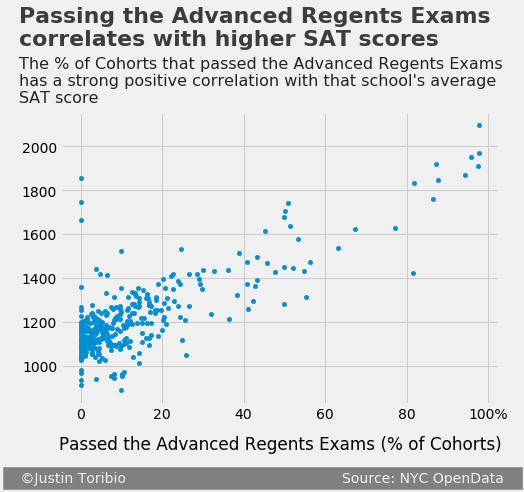

In [5]:
# Assign the text of the scatter plot to variables.
title = ("Passing the Advanced Regents Exams\n"
         "correlates with higher SAT scores")
subtitle = ("The % of Cohorts that passed the Advanced Regents Exams\n"
            "has a strong positive correlation with that school's average\n"
            "SAT score")
x_axis_label = "Passed the Advanced Regents Exams (% of Cohorts)"
signature = ("   ©Justin Toribio                              "
             "                  Source: NYC OpenData   ")

# Create the scatter plot, add the text and display the plot.
style.use("fivethirtyeight")
graph = data.plot.scatter(x="Advanced Regents - % of cohort", y="sat_score",
                          figsize=[7,5])
graph.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80", "100%"])
graph.set_xlabel(x_axis_label, labelpad=14)
graph.yaxis.label.set_visible(False)
graph.text(s=title, x=-15, y=2460, fontsize=22, weight="bold", alpha=.75)
graph.text(s=subtitle, x=-15, y=2200, fontsize=16, alpha=.85)
graph.text(s=signature, x=-18, y=470, fontsize=14, color="#f0f0f0",
           backgroundcolor="grey")
plt.show()

Schools that have a higher percentage of Cohorts that passed the Advanced Regents Exams also tend to have higher average SAT scores (the correlation coefficient between the two variables is approximately 0.8).  This is a reasonably intuitive expectation: students who are able to pass the more rigorous and challenging Advanced Regents Exams would be expected to score highly on the SAT as well.  

### The geographic pattern of passing the Advanced Regents Exams mirrors SAT scores

Next we will map the school districts by percentage of total Cohorts that passed the Advanced Regents Exams.  This will let us see any geographic patterns in the data.  We will call our `create_nyc_map` function to generate the map.

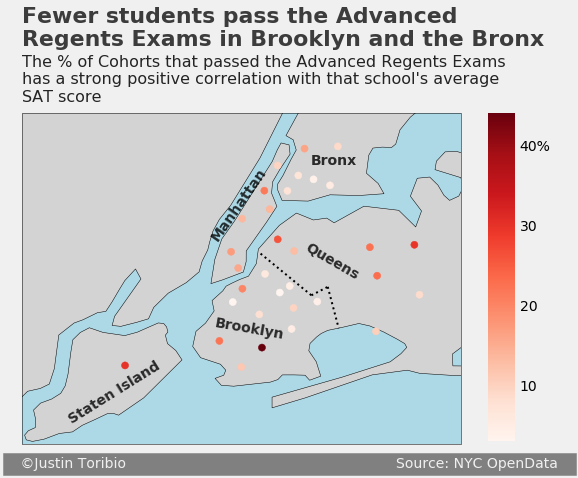

In [6]:
# Assign the title and subtitle of the map to variables.
title = ("Fewer students pass the Advanced\n"
         "Regents Exams in Brooklyn and the Bronx")
subtitle = ("The % of Cohorts that passed the Advanced Regents Exams\n"
            "has a strong positive correlation with that school's average\n"
            "SAT score")

# Create and display the map.
create_nyc_map("Advanced Regents - % of cohort", title=title, title_y_adj=-.02,
               subtitle=subtitle, colorbar_ticks=[10, 20, 30, 40], 
               colorbar_tick_labels=[10, 20, 30, "40%"])
plt.show()

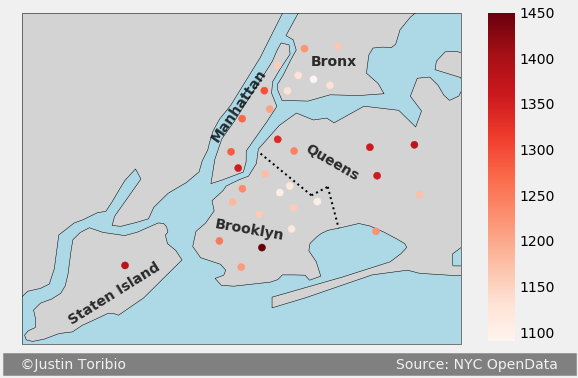

In [13]:
create_nyc_map("sat_score")
plt.show()

In [49]:
def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

TypeError: Image data cannot be converted to float

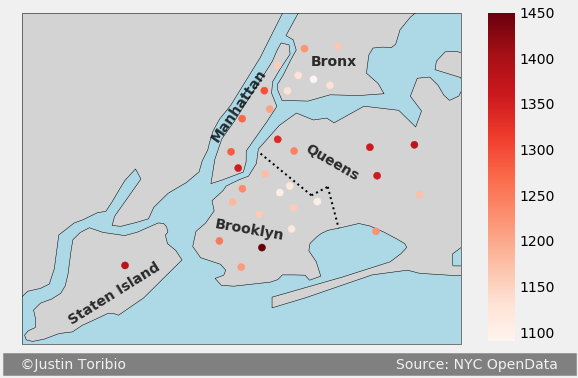

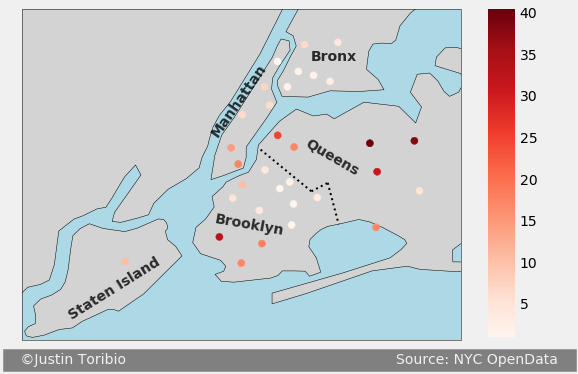

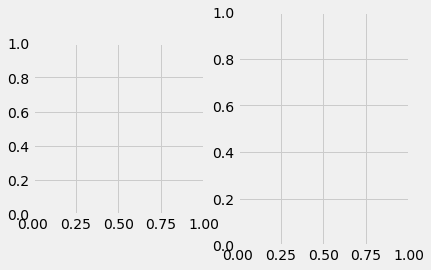

In [50]:
fig1, ax1 = create_nyc_map("sat_score")
fig2, ax2 = create_nyc_map("asian_per")

dictionary = {
    "SAT": fig1,
    "Asians": fig2
}

plot_figures(dictionary, 1, 2)

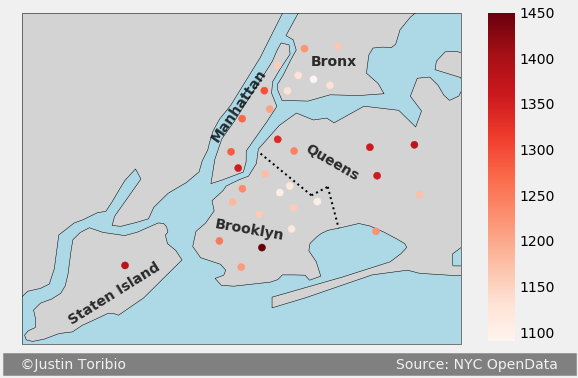

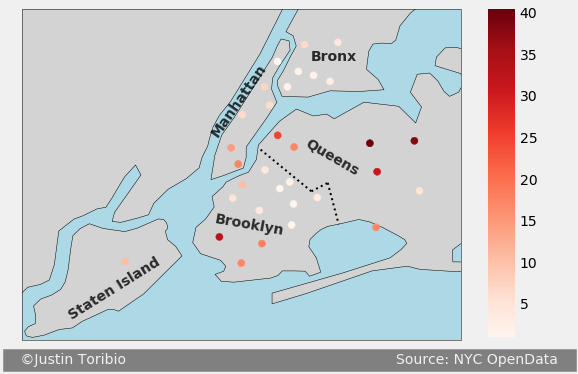

In [40]:
fig1, ax1 = create_nyc_map("sat_score")
fig2, ax2 = create_nyc_map("asian_per")

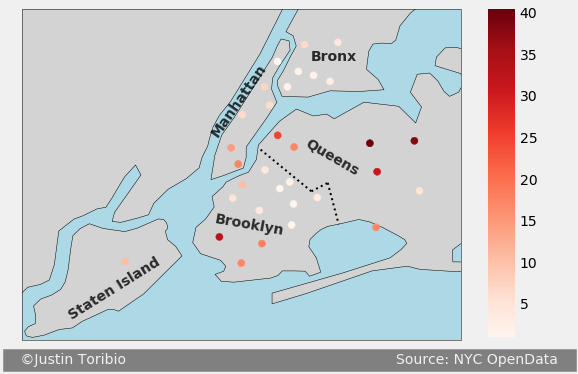

In [52]:
fig2

<Figure size 432x288 with 0 Axes>

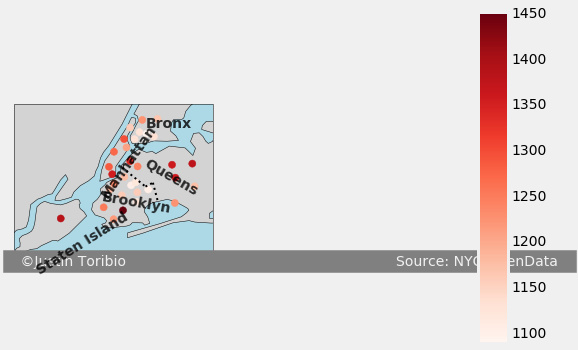

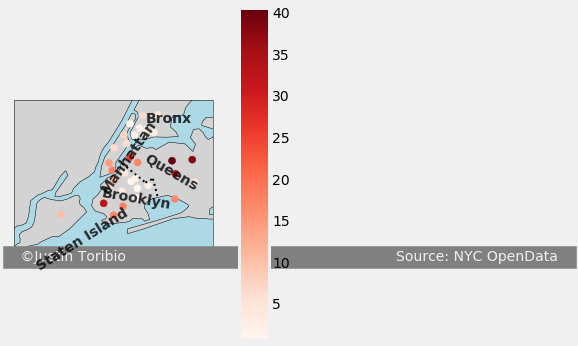

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [39]:
def plot_axes(ax, fig=None, geometry=(1,1,1)):
    if fig is None:
        fig = plt.figure()
    if ax.get_geometry() != geometry:
        ax.change_geometry(*geometry)
    ax = fig.axes.append(ax)
    
    return fig

fig1, ax1 = create_nyc_map("sat_score")
fig2, ax2 = create_nyc_map("asian_per")

plot_axes(ax1, geometry=(1,2,1))
plot_axes(ax2, geometry=(1,2,2))

<Figure size 504x504 with 0 Axes>

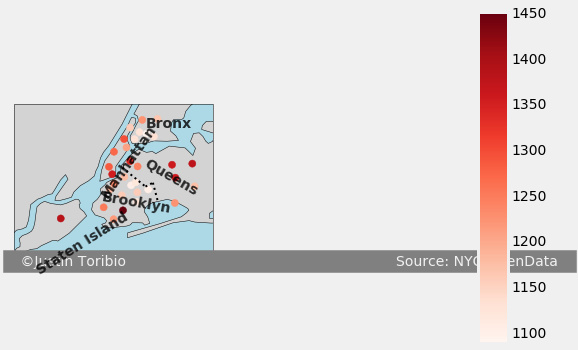

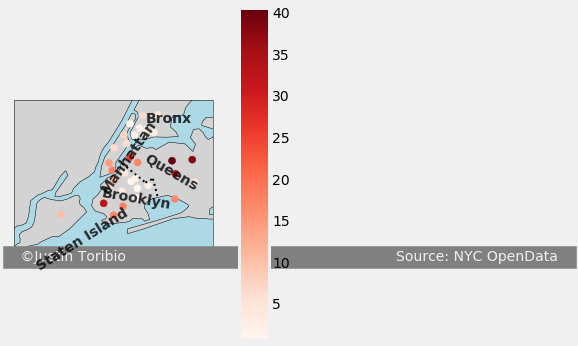

In [37]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=[7,7])
gs = gridspec.GridSpec(1,2)

fig1, ax1 = create_nyc_map("sat_score")
fig2, ax2 = create_nyc_map("asian_per")

fig.axes.append(ax1)
fig.axes.append(ax2)

ax1.change_geometry(1,2,1)
ax2.change_geometry(1,2,2)

plt.show()

Interestingly, the majority of Manhattan's school districts are on the low end of the range, while still having SAT scores on the mid to high end of the range.  

Every district that has a high % of Cohorts that pass the Advanced Regents Exams also has high SAT scores.  

This suggests a school can have high SAT scores while not necessarily having a high percentage of Cohorts that pass the Advanced Regents Exams (perhaps the school has a lot of high-performing students that decide not to pursue the Regents Diploma with Advanced Designation, for whatever reason).  

However, it is unlikely that a school with a high percentage of Cohorts that pass the Advanced Regents Exams will have low SAT scores.  Again, this is intuitive: a lot of students passing the more difficult Advanced Regents Exams would be expected to perform well on the SAT as well.

### Percentage of total Cohorts that graduated with a Local Diploma  

A Local Diploma is an option for students who can't get above a score of 65 on all of their Regents Exams, but can get above at least a 45.

`"Local - % of grads"` represents the percentage of total Cohorts that graduated with a Local Diploma in each school.  It is reasonable to expect that a high % of students who graduate with a Local Diploma would correlate with low SAT scores.  

# Exploring AP data and SAT scores  

`"Num of AP Test Takers"` represents the number of students that have taken AP tests.

In [ ]:
data.plot(x="total_enrollment", y="sat_score", kind="scatter")
correlations["total_enrollment"]

# Exploring schools with low SAT scores and enrollment... why am I plotting this???

In [ ]:
low_enrollment = data[data["total_enrollment"] < 1000]
low_enrollment = data[data["sat_score"] < 1000]
print(low_enrollment.shape)
low_enrollment[["SCHOOL NAME", "total_enrollment", "sat_score"]]

# Plotting language learning percentage

In [ ]:
data.plot(x="ell_percent", y="sat_score", kind="scatter")
correlations["ell_percent"]

# Mapping the schools

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

fig = plt.figure(figsize=(7,7))

# make this subplot a little bit wider somehow??? Or figure out how to change cartopy subplot bg color
ax1 = fig.add_subplot(111)
ax1.set_facecolor("lightblue")
ax1.tick_params(
    axis='both', which='both', bottom=False,
    top=False, left=False, right=False,
    labelleft=False, labelbottom=False
    )

ax2 = fig.add_subplot(111, projection=ccrs.Mercator())
ax2.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax2.background_patch.set_fill(False)
ax2.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat

fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

longitudes = data["lon"].tolist()
latitudes = data["lat"].tolist()

ax.scatter(longitudes, latitudes, transform=ccrs.PlateCarree(), s=20, zorder=4)

# Plotting out statistics

In [ ]:
fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

ax.scatter(longitudes, latitudes, s=20, zorder=2, c=data["ell_percent"], cmap="summer")

# Calculating district level statistics

In [ ]:
import numpy as np

districts = data.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)

districts.head()

# Plotting "percent of English learners" by district

In [ ]:
fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

ax.scatter(longitudes, latitudes, s=50, zorder=2, c=districts["ell_percent"], cmap="summer")

# Correlation between survey results and SAT scores

In [ ]:
survey_fields_with_SAT = [
    "DBN",
    "sat_score",
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
    ]

corr_survey_sat = data.loc[:, survey_fields_with_SAT].corr()
corr_survey_sat = corr_survey_sat["sat_score"][1:]

corr_survey_sat.plot.barh()

Mine: Academic expectations and safety and respect scores have strong r-values with SAT scores. Makes sense, hard to learn in an unsafe environment, and I'd expect high achieving students with high expectations of a school to perform well academically at that school.

Solution: There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers perceived safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

# Exploring safety and SAT scores

In [ ]:
data.plot.scatter(x="saf_s_11", y="sat_score")

Mine: Doesn't appear to be a strong linear correlations, weak at best.

Solution: There appears to be a correlation between SAT scores and safety, although it isn't that strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

In [ ]:
fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

ax.scatter(longitudes, latitudes, s=50, zorder=2, c=districts["saf_s_11"], cmap="summer")

Mine: Safest schools are in Manhattan as expected. With exception of a few, the least safe schools are in Brooklyn, Queens and the Bronx

Solution: It looks like Upper Manhattan and parts of Queens and the Bronx tend to have lower safety scores, whereas Brooklyn has high safety scores.

# Exploring race and SAT scores

In [ ]:
race_cols = ["sat_score", "white_per", "asian_per", "black_per", "hispanic_per"]
race_sat = data[race_cols].corr()["sat_score"][1:]
race_sat.plot.barh()

Mine: Asian and White are strongly positively correlated. Hispanic and Black are strongly negatively correlated.  Possibly suggests racial bias in test, or indicative of lack of funding for schools in areas with high % of hispanic and black students.

Solution: It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

In [ ]:
data.plot.scatter("hispanic_per", "sat_score")

Mine: appears to be negative correlation, although not that strong. Schools with greater than approx 25% Hispanic don't have an SAT score above around 1500

In [ ]:
data[data["hispanic_per"] > 95]["SCHOOL NAME"]

Solution: The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [ ]:
hisp_10_1800 = data[data["hispanic_per"] < 10]
hisp_10_1800[hisp_10_1800["sat_score"] > 1800]["SCHOOL NAME"]

Mine: all appear to be science and technical schools, suggesting higher acceptance requirements, and hence higher achieving students

Solution: Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

# Exploring gender and SAT scores

In [ ]:
sex_cols = ["sat_score", "male_per", "female_per"]
sex_sat = data[sex_cols].corr()["sat_score"][1:]
sex_sat.plot.barh()

Mine: females positive corr, males negative corr, but neither are strong.

Solution: In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

In [ ]:
data.plot.scatter("female_per", "sat_score")

Mine: don't see any strong linear corr.  There's high and low sat scores with high and low female_per

Solution: Based on the scatter plot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [ ]:
fem_60_1700 = data[data["female_per"] > 60]
fem_60_1700[fem_60_1700["sat_score"] > 1700]["SCHOOL NAME"]

Solution: These schools appears to be very selective liberal arts schools that have high academic standards

# Exploring AP scores vs SAT scores

In [ ]:
data["ap_per"] = data["Num of AP Test Takers"] / data["total_enrollment"]
data.plot.scatter("ap_per", "sat_score")

Mine: some corr but not strong. There is a cluster of schools with ap_per > .4 with high SAT, but also a bunch with very high ap_per with SAT no greater than 1200

Solution: It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

# Conclusion